# Artificial Intelligence Spring 99 <img src = 'https://ece.ut.ac.ir/cict-theme/images/footer-logo.png' alt="Tehran-University-Logo" width="150" height="150" align="right">
## Project Final : Price Estimator Using Regression
### Dr. Hakimeh Fadaei
### By Omid Vaheb

## Introduction:
In this project, after inspecting data, I prepared and normalized it for implementing learning algorithms on it. The most significant barrier in the way was doing preprocessing for texts in persian but I handled it with Hazm library. The final step was to enhance and set hyperparameters for some regression models to get the maximum accuracy and minimum MSE from each model.
## Question:
In order to predict price of a cellphone in Iran's market we need to build a model using machine learning algorithms. The dataset we used in this project was Divar.com 's real data from 5 years ago. Divar is a site in which peaple post an ad for their product to sell them. First we train the model using the given dataset. This data set consists of Brand, Title of ad,  price, description of ad, date in which the was added, number of images uploaded with the ad.

Before anything we import libraries needed in the project.

In [60]:
from __future__ import unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
import itertools
import gc
#!pip install hazm
import hazm
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
#!pip install lightgbm
import random
import lightgbm as lgb
from lightgbm import LGBMRegressor
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

Now it is time to inspect data by some simple commands.

In [2]:
data = pd.read_csv('mobile_phone_dataset.csv')
data.head(10)

,Unnamed: 0,brand,city,title,desc,image_count,created_at,price
0,0,Nokia::نوکیا,Qom,نوکیا6303,سلام.یه گوشیه6303سالم که فقط دوتا خط کوچیک رو ...,2,Wednesday 07AM,60000
1,1,Apple::اپل,Tehran,ایفون ٥اس٣٢گیگ,درحد نو سالم اصلى بدون ضربه مهلت تست میدم,0,Wednesday 11AM,1150000
2,2,Samsung::سامسونگ,Mashhad,سامسونگ j5,گوشى بسیار بسیار تمیز و فقط سه هفته کارکرده و ...,2,Wednesday 02PM,590000
3,3,Apple::اپل,Karaj,گرى 5s ایفون 32گیگ,گلس پشت و رو .کارت اپل ای دی. لوازم جانبی اصلی...,3,Wednesday 04PM,1100000
4,4,Samsung::سامسونگ,Tehran,galaxy S5 Gold در حد آک,کاملا تمیز و بدون حتی 1 خط و خش\nبه همراه گلاس...,2,Friday 01PM,900000
5,5,Nokia::نوکیا,Karaj,8800 sirocco,بسیار تمیز با کلیه لوازم-گوشی اصل(المان)-شارژر...,4,Saturday 09AM,800000
6,6,Nokia::نوکیا,Tehran,معاوضه نوکیا ۲۱۵ با مودم 4g USB,فروش گوشی طرح نوکیا ۲۱۵\nاین گوشی طرح می باشد....,1,Saturday 05PM,40000
7,7,Samsung::سامسونگ,Tehran,پریم گرند سالم,تعمیر نرفته,1,Saturday 05PM,310000
8,8,Apple::اپل,Tehran,ایفون ٦ (٦٤),ایفون بسیار تمیز \nاز هر لحاظ سالم,0,Sunday 01PM,1700000
9,9,Huawei::هوآوی,Shiraz,گوشی هواوی Y625,گوشیو هیچ ضربه نخورده وبه شرت میدم,3,Tuesday 12PM,250000


It is clear that we don't have any nan value but there are -1 in prices and there is an index column which does not help.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59189 entries, 0 to 59188
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   59189 non-null  int64 
 1   brand        59189 non-null  object
 2   city         59189 non-null  object
 3   title        59189 non-null  object
 4   desc         59189 non-null  object
 5   image_count  59189 non-null  int64 
 6   created_at   59189 non-null  object
 7   price        59189 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 3.6+ MB


In [4]:
data.describe()

,Unnamed: 0,image_count,price
count,59189.000000,59189.000000,5.918900e+04
mean,31071.921725,1.642974,6.202780e+05
std,17947.312101,1.371340,5.616647e+05
min,0.000000,0.000000,-1.000000e+00
25%,15531.000000,0.000000,2.000000e+05
50%,31082.000000,2.000000,4.500000e+05
75%,46618.000000,3.000000,9.000000e+05
max,62175.000000,11.000000,2.800000e+06


We can see that there are less than 400 rows with price less than 10000 (which is clearly a mistype) so we can drop them because they are below 1% of dataset and are not worth fixing.

In [5]:
data = data.drop(columns = ['Unnamed: 0'])
data.loc[(data.price <= 10000) & (data.price != -1)]

,brand,city,title,desc,image_count,created_at,price
128,Apple::اپل,Qom,ایفون 4s,بسیار بسیار تمیز رنگ سفید به همراه لیبر پشت و ...,0,Monday 04PM,600
478,Apple::اپل,Shiraz,کوشی موبایل ٤اس فروشی,تازه خریده هیج خط وخشی هم نداره همه جی هم داره...,0,Friday 11AM,600
773,HTC::اچ‌تی‌سی,Shiraz,اچ تی سی چاچا,گوشی کاملا سالم میباشد.,2,Thursday 10AM,100
997,Nokia::نوکیا,Qom,نوکیا 1280,تخفیف نداره کارتن وشارجر داره,0,Tuesday 03PM,5000
1685,Apple::اپل,Shiraz,گوشی فایو اپل,باسلام گوشی ایفون سالم سالممم تمیزز در حد نو ع...,3,Friday 10AM,900
...,...,...,...,...,...,...,...
58590,Apple::اپل,Tehran,آیفون 6s گلد 128 گیگ,نو نو نو نو نو نو نو نو نو در حد آکبند بدونه خ...,2,Thursday 09AM,2600
58759,Apple::اپل,Mashhad,اپل 5S,خریدم برام سخته کار کردنش میخوام بفروشم.پول لازمم,1,Friday 04AM,750
58830,Apple::اپل,Tehran,اپل ٦ /١٦ گیگ خیلی تمیز,گوشی خیلی تمیزه \nمعاوضه با رده پاین تر دارم,5,Friday 08AM,1500
58845,Apple::اپل,Tehran,١٦آیفون 6sرز گلد,بدون نقطه خط و خش رنگ زیبای رزگلد معاوضه ندارم...,0,Thursday 03PM,1750


In [6]:
dataframe = data.loc[(data.price > 10000) | (data.price == -1)]

In [7]:
dataframe.loc[(dataframe.price <= 10000) & (dataframe.price != -1)]

,brand,city,title,desc,image_count,created_at,price


Now we check the upper limit of price and there are not many anomalies so we don't do anything with them.

In [8]:
dataframe.loc[(dataframe.price > 2000000)]

,brand,city,title,desc,image_count,created_at,price
19,Apple::اپل,Ahvaz,ایفون ۶ اس ۶۴در حد اک با تمامی وسایل,هندزفری پلمب،گلس ۳دی جلو و گلس پشت،محافظ دوربی...,3,Sunday 01PM,2360000
24,Apple::اپل,Tehran,Iphone 6s 64Gb Gold,بسیار تمیز و سالم ، فوری ، فقط فروش,1,Wednesday 06PM,2250000
42,Apple::اپل,Tehran,Iphone 6s,گوشی کاملا سالم بدون کوچکترین خطو خش\n64g\nLLA...,2,Sunday 10AM,2400000
246,Apple::اپل,Tehran,آیفون ٦اس پلاس,ایفون ٦اس پلاس ١٢٨. مشکی\nکاملا سالم و نو. خر...,3,Saturday 04PM,2450000
266,Apple::اپل,Tehran,IPhone 6s 64G آکبند,زیر قیمت بازار پک اصلی تخفیف پای معامله,2,Tuesday 08AM,2430000
...,...,...,...,...,...,...,...
59023,Apple::اپل,Tehran,آیفون 6 اس رزگلد 64 - iphone 6s rose 64,iphone 6s rose gold 64 gig\nآیفون رزگلد 64گیگ ...,2,Sunday 05AM,2050000
59046,Apple::اپل,Tehran,iphone 6s rose gold,٦٤ گیگ \nاکبند \nLLA,2,Monday 06PM,2430000
59050,Apple::اپل,Tehran,ایفون 6s گری LLA,بسیار تمیز بدون خط خش دوماه کارکرده فقط خریدا...,1,Tuesday 04PM,2150000
59082,Apple::اپل,Tehran,اپل 6s plus128 بدون خط وخش,١٢٨ گیگ کاملا سالم Lla بدون خط وخش با لوازم و...,3,Thursday 08AM,2350000


In [9]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58803 entries, 0 to 59188
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   brand        58803 non-null  object
 1   city         58803 non-null  object
 2   title        58803 non-null  object
 3   desc         58803 non-null  object
 4   image_count  58803 non-null  int64 
 5   created_at   58803 non-null  object
 6   price        58803 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 3.6+ MB


In [10]:
dataframe.isnull().sum()

brand          0
city           0
title          0
desc           0
image_count    0
created_at     0
price          0
dtype: int64

Now is the time to visualize and check the distribution of data regarding different features. First we check brand and we can see that Samsung is the most common brand in ads and after that is Apple.

In [11]:
dataframe.brand.describe()

count                58803
unique                   9
top       Samsung::سامسونگ
freq                 19710
Name: brand, dtype: object

Text(0, 0.5, 'Count')

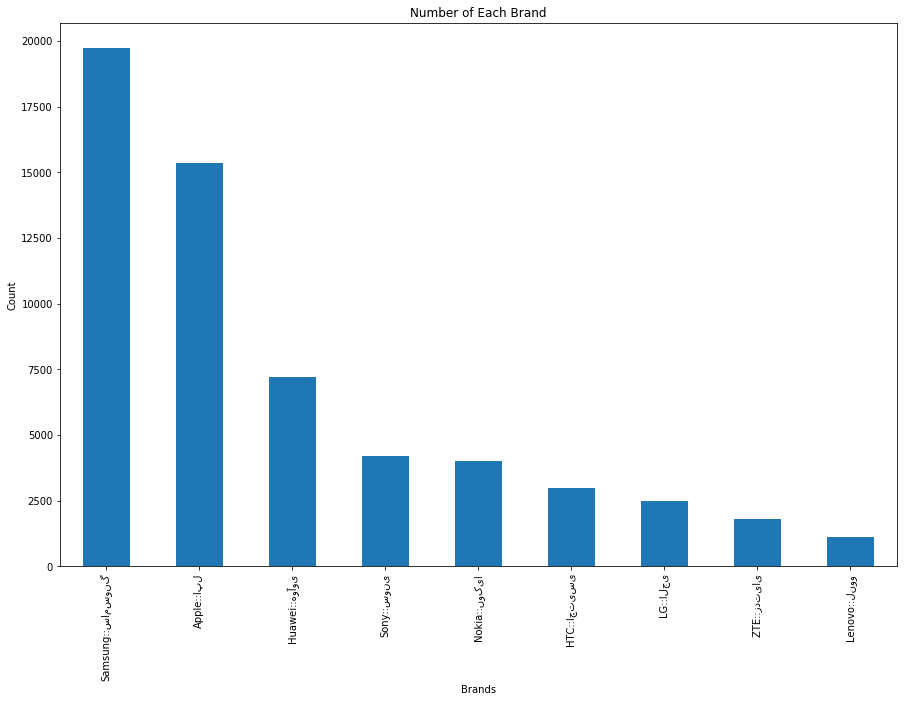

In [12]:
ax = dataframe['brand'].value_counts().plot(kind = 'bar',
                                    figsize = (15, 10),
                                    title = "Number of Each Brand");
ax.set_xlabel("Brands")
ax.set_ylabel("Count")

We do this visualization for city of the person who posted ad too.

In [13]:
dataframe.city.describe()

count      58803
unique         9
top       Tehran
freq       21692
Name: city, dtype: object

Text(0, 0.5, 'Count')

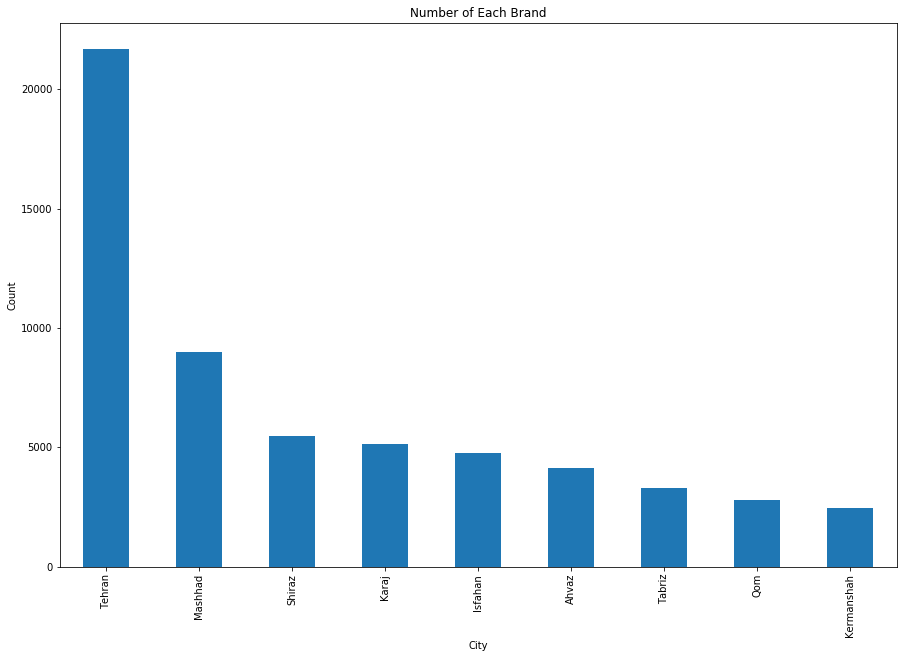

In [14]:
ax = dataframe['city'].value_counts().plot(kind = 'bar',
                                    figsize = (15, 10),
                                    title = "Number of Each Brand");
ax.set_xlabel("City")
ax.set_ylabel("Count")

Now it is time to handle rows with -1 as price. I chose to replace them with mean of their category because it doesn't affect the data that much and droping them would have destroyed randomness of data.

In [15]:
dataframe.loc[dataframe.price == -1]

,brand,city,title,desc,image_count,created_at,price
23,Samsung::سامسونگ,Karaj,A3 2015,گوشی در حده نو کلا 2 هفتس خریدمش.با تشکر از سا...,1,Tuesday 12PM,-1
28,Apple::اپل,Qom,اپل 5s ٣٢ گیگ بسیار تمیز در حد,گوشی بسیار تمیز در حد قیمت مقطوع میباشد لطفا ت...,2,Saturday 04AM,-1
32,Apple::اپل,Shiraz,اقساط٢٤ماهه بدون پیش پرداخت,اقساط ٢٤ماهه بدون پیش پرداخت,0,Sunday 03PM,-1
36,Sony::سونی,Qom,سونی مدل acro s گوشی هواوی y300,"گوشی سونی مدل acro s دوربین 12 فیلمبرداری HD ,...",2,Thursday 06AM,-1
44,HTC::اچ‌تی‌سی,Tehran,ّگوشی موبایل htc desire610 جهت معاوضه,معاوضه با ایفون 4\nگوشیم سالم سالم 4g\nبدون هی...,0,Monday 08PM,-1
...,...,...,...,...,...,...,...
59121,Lenovo::لنوو,Karaj,گوشی موبایل HuaweiG610,دست دوم خیلی نو فقط هارد گوشی سوخته باید تعمیر...,3,Tuesday 11AM,-1
59146,Samsung::سامسونگ,Karaj,گوشی سامسونگ گلکسی مینی اندروید,گوشی سامسونگ گلکسی مینی اندروید\nتمیز \nدر حد نو,3,Wednesday 01PM,-1
59169,Apple::اپل,Shiraz,iPhone SE 16GB / RoseGold,آیفون فوق بسیار تمیز و در حد نو می‌باشد(بدون ه...,4,Sunday 12PM,-1
59174,Samsung::سامسونگ,Mashhad,نوت 5گلدتک سیم درحدمعاوضه فقط با 5sیا6s,در حد اک ۳۲گیگ معاوضه فقط با اپل ۵اس یا ۶اس ۶۴...,0,Tuesday 10AM,-1


In [16]:
dataframe.tail(10)

,brand,city,title,desc,image_count,created_at,price
59179,Apple::اپل,Tehran,ایفون ٦اس ٦٤ گیگ,ایفون ٦اس ٦٤ گیگ\nگرى LLA \nگوشى از همه نظر س...,5,Saturday 04AM,1950000
59180,Samsung::سامسونگ,Tabriz,Samsung galaxy fit,3g\nHotspot\nWifi\nاندروید\nGps\nبدون ایراد دا...,2,Saturday 06PM,95000
59181,LG::ال‌جی,Karaj,گوشی LG L50 Dual Sim,دوسیم کارت-3g-دوربین3.2- حافظه‌ داخلی 4 گیگابا...,0,Sunday 11AM,180000
59182,Samsung::سامسونگ,Tehran,گوشی A3 سفید انروید ۵ سلام به شرط,گوشی سالم هستش دارم میرم خدمت مجبورم بفروشم هم...,3,Monday 09PM,495000
59183,Huawei::هوآوی,Shiraz,هواوی g6قابل توجه تعمیر کاران,هواوی G6با تمام لوازم و کارتن روی بوت,0,Tuesday 03PM,-1
59184,Apple::اپل,Tehran,گوشی موبایل ایفون(4S (32GB,گوشی موبایل ایفون 4S\n32 گیگ سفید سالم دکمه هو...,3,Tuesday 03PM,500000
59185,LG::ال‌جی,Mashhad,گوشی ال جی k10تمیزومرتب بدون خط وخش,گوشی ال جی سالم وبدون کوچکترین ایرادوبدون خط و...,3,Tuesday 05PM,520000
59186,Apple::اپل,Tehran,/١٦gig/5s/گلد,جعبه ولوازم LLAاصل/بدون خط وخش/باز نشده/سالم.,2,Wednesday 11AM,720000
59187,Samsung::سامسونگ,Tehran,گلکسی galaxy s4 i9500,سالم و تمیز با لوازم\nاندروید 5. باتری اورجینا...,2,Thursday 09AM,475000
59188,Sony::سونی,Mashhad,سونی Z2فورجی سفیدD6503,فروش یا معاوضه فوری فوری\nسفید تمیز همراه با گ...,0,Thursday 11AM,650000


In [17]:
dataframe = dataframe.replace(-1, np.nan)
dataframe['price'] = dataframe.groupby('brand')['price'].transform(lambda grp: grp.fillna(np.mean(grp)))

In [18]:
dataframe.loc[dataframe.price == -1]

,brand,city,title,desc,image_count,created_at,price


In [19]:
dataframe.tail(10)

,brand,city,title,desc,image_count,created_at,price
59179,Apple::اپل,Tehran,ایفون ٦اس ٦٤ گیگ,ایفون ٦اس ٦٤ گیگ\nگرى LLA \nگوشى از همه نظر س...,5,Saturday 04AM,1.950000e+06
59180,Samsung::سامسونگ,Tabriz,Samsung galaxy fit,3g\nHotspot\nWifi\nاندروید\nGps\nبدون ایراد دا...,2,Saturday 06PM,9.500000e+04
59181,LG::ال‌جی,Karaj,گوشی LG L50 Dual Sim,دوسیم کارت-3g-دوربین3.2- حافظه‌ داخلی 4 گیگابا...,0,Sunday 11AM,1.800000e+05
59182,Samsung::سامسونگ,Tehran,گوشی A3 سفید انروید ۵ سلام به شرط,گوشی سالم هستش دارم میرم خدمت مجبورم بفروشم هم...,3,Monday 09PM,4.950000e+05
59183,Huawei::هوآوی,Shiraz,هواوی g6قابل توجه تعمیر کاران,هواوی G6با تمام لوازم و کارتن روی بوت,0,Tuesday 03PM,3.529826e+05
59184,Apple::اپل,Tehran,گوشی موبایل ایفون(4S (32GB,گوشی موبایل ایفون 4S\n32 گیگ سفید سالم دکمه هو...,3,Tuesday 03PM,5.000000e+05
59185,LG::ال‌جی,Mashhad,گوشی ال جی k10تمیزومرتب بدون خط وخش,گوشی ال جی سالم وبدون کوچکترین ایرادوبدون خط و...,3,Tuesday 05PM,5.200000e+05
59186,Apple::اپل,Tehran,/١٦gig/5s/گلد,جعبه ولوازم LLAاصل/بدون خط وخش/باز نشده/سالم.,2,Wednesday 11AM,7.200000e+05
59187,Samsung::سامسونگ,Tehran,گلکسی galaxy s4 i9500,سالم و تمیز با لوازم\nاندروید 5. باتری اورجینا...,2,Thursday 09AM,4.750000e+05
59188,Sony::سونی,Mashhad,سونی Z2فورجی سفیدD6503,فروش یا معاوضه فوری فوری\nسفید تمیز همراه با گ...,0,Thursday 11AM,6.500000e+05


In the next part I ploted box plot of price to check distribution of this feature.

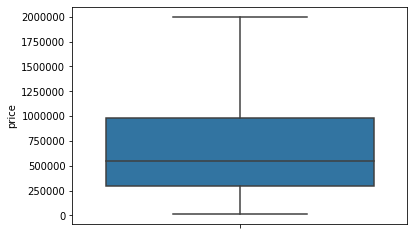

In [20]:
sns.boxplot(y = 'price', data = dataframe, showfliers = False)
plt.show()

In the next part I drew scatterplot of dataset regarding brand, city and image_count which is clear that image count does not give any useful information and we should drop it since the regression line for it is absoloutly a horizontal line.

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

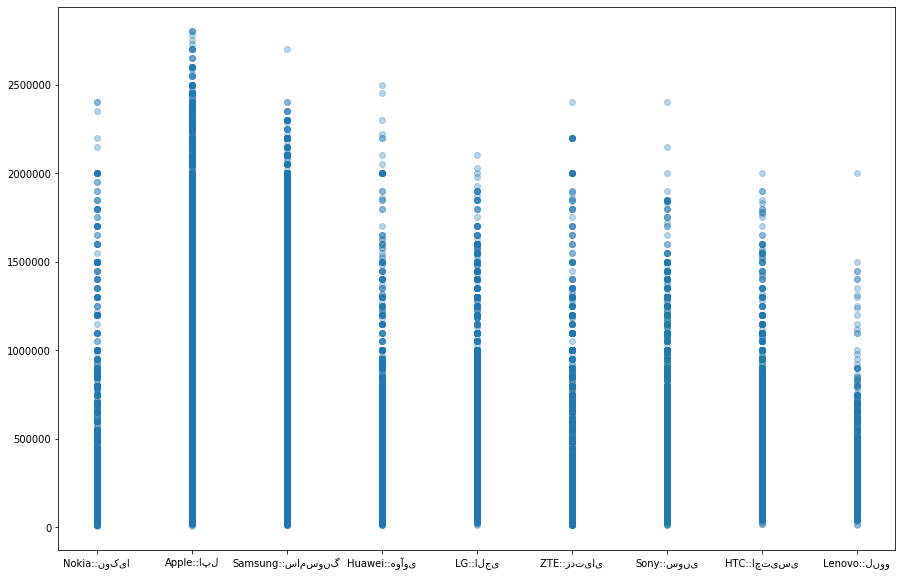

In [21]:
plt.figure(figsize=(15,10))
chart = sns.regplot(x = 'brand', y = 'price', data = dataframe,
            scatter_kws = {'alpha' : 0.3}, line_kws = {'color' : 'orange'})

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

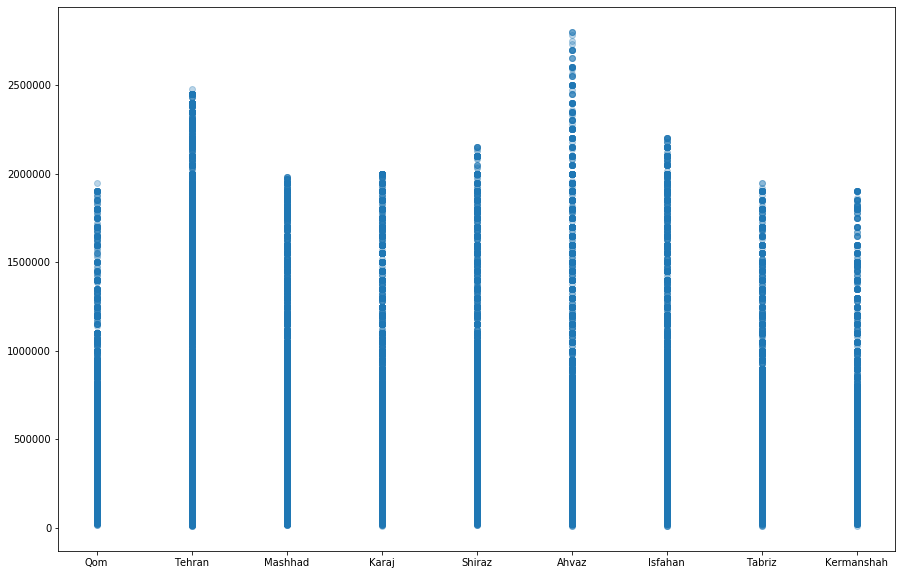

In [22]:
plt.figure(figsize=(15,10))
chart = sns.regplot(x = 'city', y = 'price', data = dataframe,
            scatter_kws = {'alpha' : 0.3}, line_kws = {'color' : 'orange'})

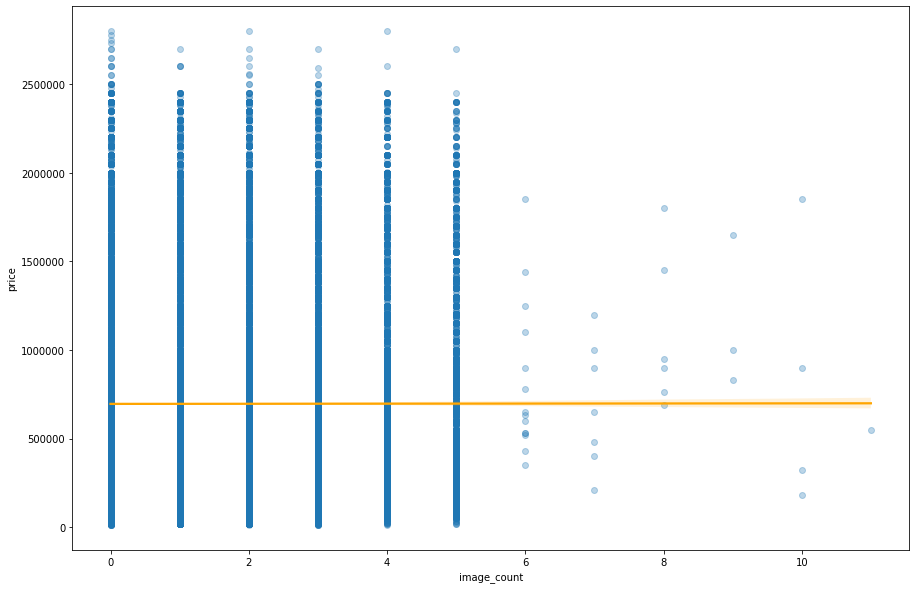

In [23]:
plt.figure(figsize=(15,10))
chart = sns.regplot(x = 'image_count', y = 'price', data = dataframe,
            scatter_kws = {'alpha' : 0.3}, line_kws = {'color' : 'orange'})

In [24]:
dataframe = dataframe.drop(columns = ['image_count'])

The next step is to handle the date that ad was added to site. At first i break this feature into 2 features of hour and day of week. Now I drew histogram of price day-wise and it is clear that general shape of dataset is similar for all days and this feature does not give us additional information. We can also use information gain for hour of the day and we can see that its gain is less than other featues. So I decided to drop this column too.

In [25]:
def dateHandler(row): 
    row['AMorPM'] = row['created_at'][-2:]
    row['hour'] = int(row['created_at'][-4:-2])
    if row['AMorPM'] == "PM":
        row['hour'] += 12
    row['day'] = re.split('\W', row['created_at'])[0]
    return row
dataframe = dataframe.apply(dateHandler, axis = 'columns')
dataframe.head(10)

,brand,city,title,desc,created_at,price,AMorPM,hour,day
0,Nokia::نوکیا,Qom,نوکیا6303,سلام.یه گوشیه6303سالم که فقط دوتا خط کوچیک رو ...,Wednesday 07AM,60000.0,AM,7,Wednesday
1,Apple::اپل,Tehran,ایفون ٥اس٣٢گیگ,درحد نو سالم اصلى بدون ضربه مهلت تست میدم,Wednesday 11AM,1150000.0,AM,11,Wednesday
2,Samsung::سامسونگ,Mashhad,سامسونگ j5,گوشى بسیار بسیار تمیز و فقط سه هفته کارکرده و ...,Wednesday 02PM,590000.0,PM,14,Wednesday
3,Apple::اپل,Karaj,گرى 5s ایفون 32گیگ,گلس پشت و رو .کارت اپل ای دی. لوازم جانبی اصلی...,Wednesday 04PM,1100000.0,PM,16,Wednesday
4,Samsung::سامسونگ,Tehran,galaxy S5 Gold در حد آک,کاملا تمیز و بدون حتی 1 خط و خش\nبه همراه گلاس...,Friday 01PM,900000.0,PM,13,Friday
5,Nokia::نوکیا,Karaj,8800 sirocco,بسیار تمیز با کلیه لوازم-گوشی اصل(المان)-شارژر...,Saturday 09AM,800000.0,AM,9,Saturday
6,Nokia::نوکیا,Tehran,معاوضه نوکیا ۲۱۵ با مودم 4g USB,فروش گوشی طرح نوکیا ۲۱۵\nاین گوشی طرح می باشد....,Saturday 05PM,40000.0,PM,17,Saturday
7,Samsung::سامسونگ,Tehran,پریم گرند سالم,تعمیر نرفته,Saturday 05PM,310000.0,PM,17,Saturday
8,Apple::اپل,Tehran,ایفون ٦ (٦٤),ایفون بسیار تمیز \nاز هر لحاظ سالم,Sunday 01PM,1700000.0,PM,13,Sunday
9,Huawei::هوآوی,Shiraz,گوشی هواوی Y625,گوشیو هیچ ضربه نخورده وبه شرت میدم,Tuesday 12PM,250000.0,PM,24,Tuesday


[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Price'),
 Text(0.5, 1.0, 'Frequency Histogram of Price in Sundays')]

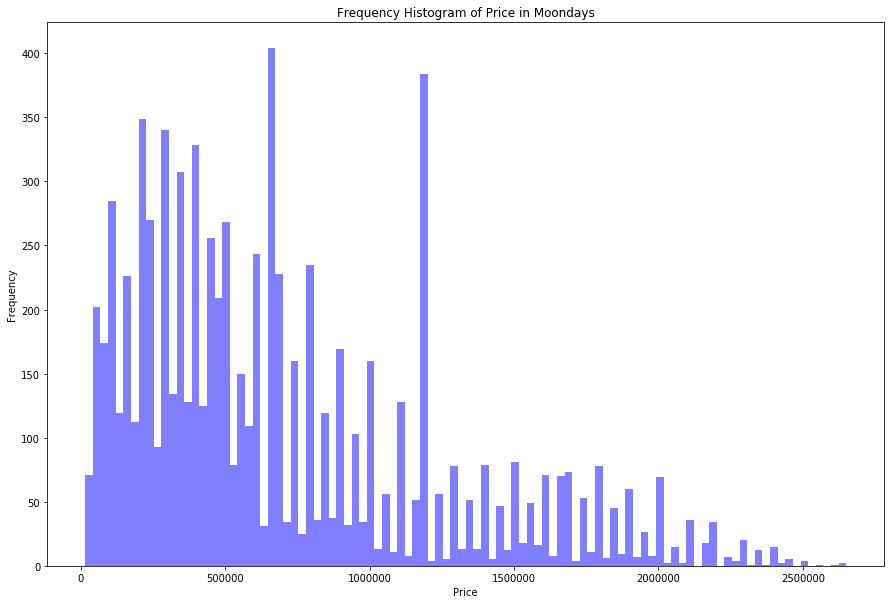

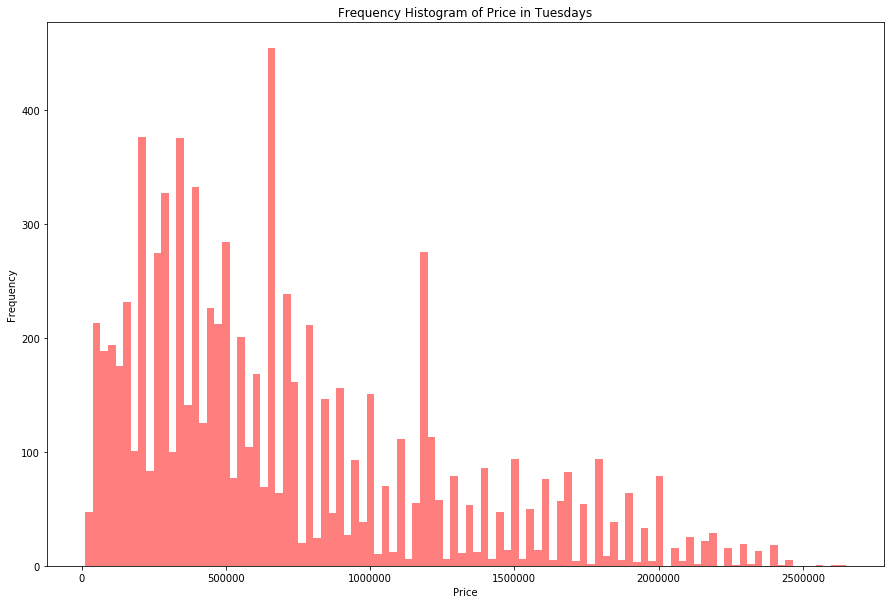

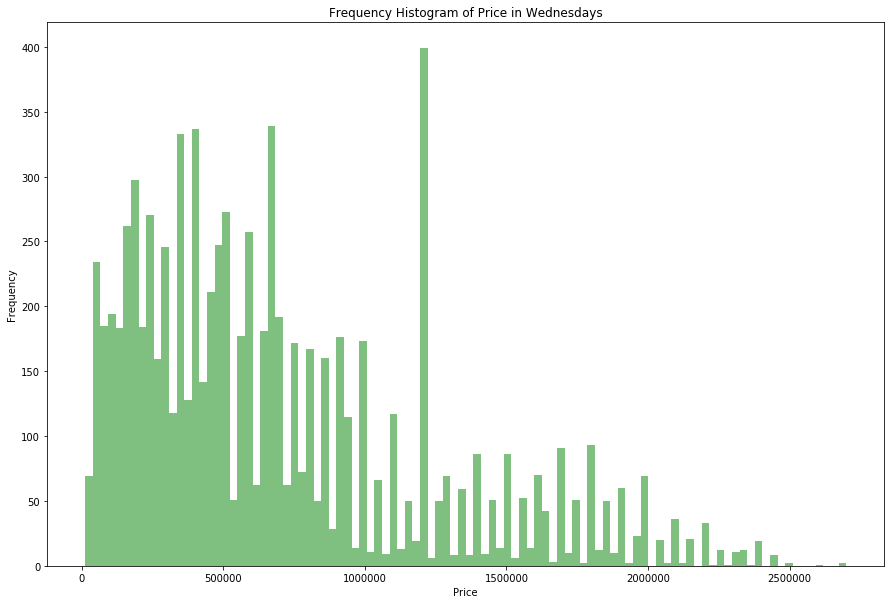

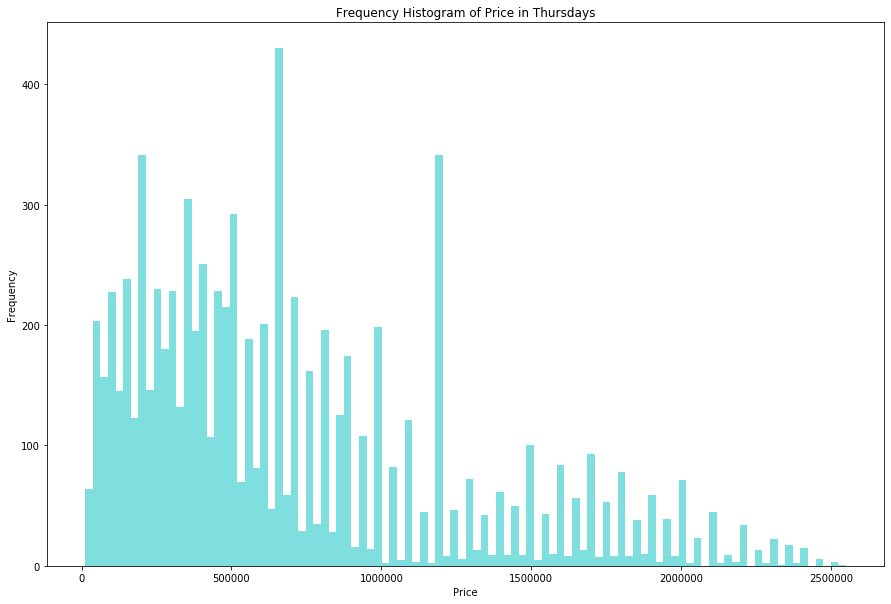

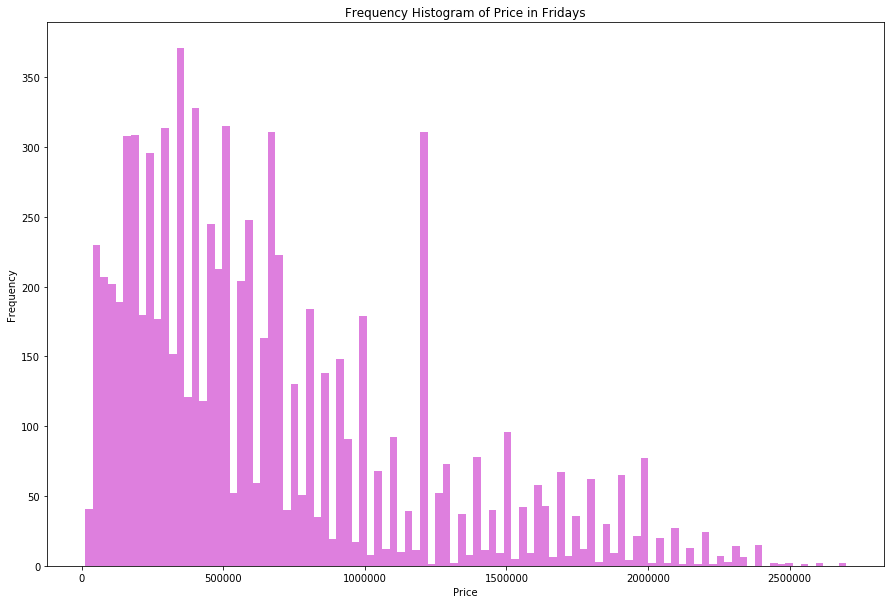

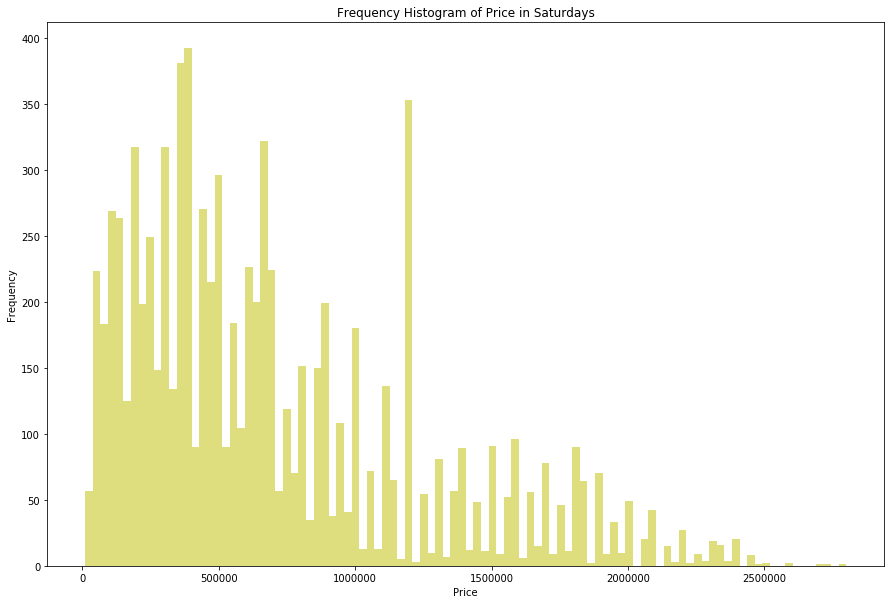

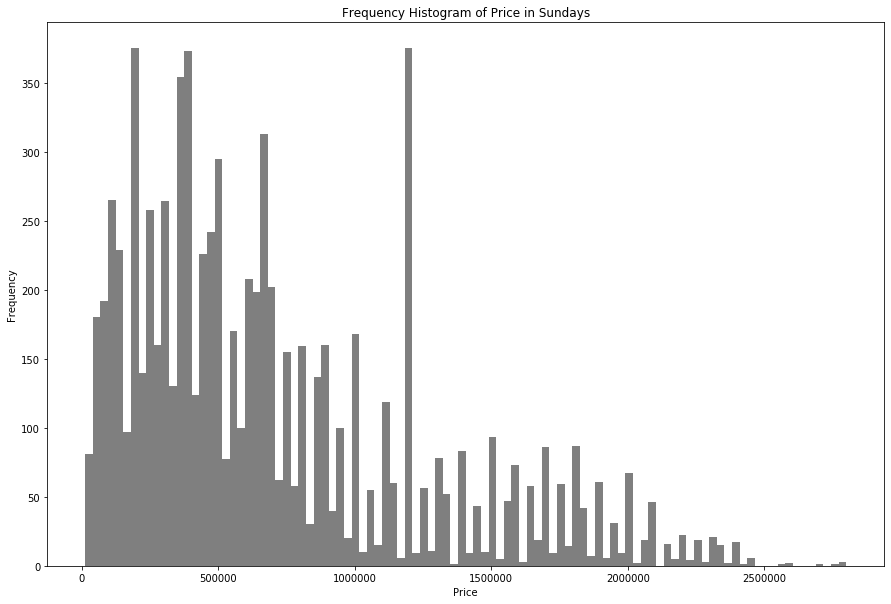

In [26]:
dataframe = dataframe.drop(columns = ['AMorPM', 'created_at'])
x1 = dataframe.loc[dataframe.day == 'Monday', 'price']
x2 = dataframe.loc[dataframe.day == 'Tuesday', 'price']
x3 = dataframe.loc[dataframe.day == 'Wednesday', 'price']
x4 = dataframe.loc[dataframe.day == 'Thursday', 'price']
x5 = dataframe.loc[dataframe.day == 'Friday', 'price']
x6 = dataframe.loc[dataframe.day == 'Saturday', 'price']
x7 = dataframe.loc[dataframe.day == 'Sunday', 'price']
plt.figure(figsize = (15,10))
kwargs = dict(alpha = 0.5, bins = 100)
plt.hist(x1, **kwargs, color = 'b', label = 'Monday')
plt.gca().set(title = 'Frequency Histogram of Price in Moondays', ylabel = 'Frequency', xlabel = 'Price')
plt.figure(figsize = (15,10))
plt.hist(x2, **kwargs, color = 'r', label = 'Tuesday')
plt.gca().set(title = 'Frequency Histogram of Price in Tuesdays', ylabel = 'Frequency', xlabel = 'Price')
plt.figure(figsize = (15,10))
plt.hist(x3, **kwargs, color = 'g', label = 'Wednesday')
plt.gca().set(title = 'Frequency Histogram of Price in Wednesdays', ylabel = 'Frequency', xlabel = 'Price')
plt.figure(figsize = (15,10))
plt.hist(x4, **kwargs, color = 'c', label = 'Thursday')
plt.gca().set(title = 'Frequency Histogram of Price in Thursdays', ylabel = 'Frequency', xlabel = 'Price')
plt.figure(figsize = (15,10))
plt.hist(x5, **kwargs, color = 'm', label = 'Friday')
plt.gca().set(title = 'Frequency Histogram of Price in Fridays', ylabel = 'Frequency', xlabel = 'Price')
plt.figure(figsize = (15,10))
plt.hist(x6, **kwargs, color = 'y', label = 'Saturday')
plt.gca().set(title = 'Frequency Histogram of Price in Saturdays', ylabel = 'Frequency', xlabel = 'Price')
plt.figure(figsize = (15,10))
plt.hist(x7, **kwargs, color = 'k', label = 'Sunday')
plt.gca().set(title = 'Frequency Histogram of Price in Sundays', ylabel = 'Frequency', xlabel = 'Price')

In [27]:
dataframe = dataframe.drop(columns = ['hour', 'day'])
dataframe.head(10)

,brand,city,title,desc,price
0,Nokia::نوکیا,Qom,نوکیا6303,سلام.یه گوشیه6303سالم که فقط دوتا خط کوچیک رو ...,60000.0
1,Apple::اپل,Tehran,ایفون ٥اس٣٢گیگ,درحد نو سالم اصلى بدون ضربه مهلت تست میدم,1150000.0
2,Samsung::سامسونگ,Mashhad,سامسونگ j5,گوشى بسیار بسیار تمیز و فقط سه هفته کارکرده و ...,590000.0
3,Apple::اپل,Karaj,گرى 5s ایفون 32گیگ,گلس پشت و رو .کارت اپل ای دی. لوازم جانبی اصلی...,1100000.0
4,Samsung::سامسونگ,Tehran,galaxy S5 Gold در حد آک,کاملا تمیز و بدون حتی 1 خط و خش\nبه همراه گلاس...,900000.0
5,Nokia::نوکیا,Karaj,8800 sirocco,بسیار تمیز با کلیه لوازم-گوشی اصل(المان)-شارژر...,800000.0
6,Nokia::نوکیا,Tehran,معاوضه نوکیا ۲۱۵ با مودم 4g USB,فروش گوشی طرح نوکیا ۲۱۵\nاین گوشی طرح می باشد....,40000.0
7,Samsung::سامسونگ,Tehran,پریم گرند سالم,تعمیر نرفته,310000.0
8,Apple::اپل,Tehran,ایفون ٦ (٦٤),ایفون بسیار تمیز \nاز هر لحاظ سالم,1700000.0
9,Huawei::هوآوی,Shiraz,گوشی هواوی Y625,گوشیو هیچ ضربه نخورده وبه شرت میدم,250000.0


Now we vectorize brand and city using one hot encoding that we have used before. In this method you put a column for each possible value for feature and the value of that column is 1 if the feature said before is equal to column's value. In this dataset brand has 9 options and city has 9 too so one hot encoding is a suitable option.

In [28]:
dataframe = pd.concat([dataframe, pd.get_dummies(dataframe['city'], prefix = 'city')], axis = 1)
dataframe = pd.concat([dataframe, pd.get_dummies(dataframe['brand'], prefix = 'brand')], axis = 1)
dataframe = dataframe.drop(columns = ['brand', 'city'])

In [29]:
dataframe.head(10)

,title,desc,price,city_Ahvaz,city_Isfahan,city_Karaj,city_Kermanshah,city_Mashhad,city_Qom,city_Shiraz,...,city_Tehran,brand_Apple::اپل,brand_HTC::اچ‌تی‌سی,brand_Huawei::هوآوی,brand_LG::ال‌جی,brand_Lenovo::لنوو,brand_Nokia::نوکیا,brand_Samsung::سامسونگ,brand_Sony::سونی,brand_ZTE::زدتی‌ای
0,نوکیا6303,سلام.یه گوشیه6303سالم که فقط دوتا خط کوچیک رو ...,60000.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,ایفون ٥اس٣٢گیگ,درحد نو سالم اصلى بدون ضربه مهلت تست میدم,1150000.0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
2,سامسونگ j5,گوشى بسیار بسیار تمیز و فقط سه هفته کارکرده و ...,590000.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,گرى 5s ایفون 32گیگ,گلس پشت و رو .کارت اپل ای دی. لوازم جانبی اصلی...,1100000.0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,galaxy S5 Gold در حد آک,کاملا تمیز و بدون حتی 1 خط و خش\nبه همراه گلاس...,900000.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
5,8800 sirocco,بسیار تمیز با کلیه لوازم-گوشی اصل(المان)-شارژر...,800000.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,معاوضه نوکیا ۲۱۵ با مودم 4g USB,فروش گوشی طرح نوکیا ۲۱۵\nاین گوشی طرح می باشد....,40000.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
7,پریم گرند سالم,تعمیر نرفته,310000.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
8,ایفون ٦ (٦٤),ایفون بسیار تمیز \nاز هر لحاظ سالم,1700000.0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
9,گوشی هواوی Y625,گوشیو هیچ ضربه نخورده وبه شرت میدم,250000.0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


The final step of preprocessing is to process 2 remaining unchanged columns: Title and description
These columns contain some persian texts and they also have some few english words and characters so by using hazm and nltk libraries i cleaned these exts. The actions taken were normalization, tokenizing and lemmatizing(we saw in previous projects that it is more through and accurate than stemming). I also created my own set of stopwords regarding dataset.

In [30]:
def preprocessTextofColumn(columnName):
    normalizer = hazm.Normalizer()
    tokenizer = hazm.WordTokenizer()
    lemmatizer = hazm.Lemmatizer()
    ENGStopWords = set(stopwords.words('english'))
    PERStopWords = set(hazm.utils.stopwords_list())
    PERStopWords = PERStopWords.union({':','ی','ای',',','،','(',')',':',';','-','_','.','/','+','=','?'})
    stopWords = ENGStopWords.union(PERStopWords)
    allWords = []
    for index, row in dataframe.iterrows():
        text = row[columnName]
        normalizedText = normalizer.affix_spacing(text)
        words = tokenizer.tokenize(normalizedText)
        filteredWords = []
        for word in words:
            if not word in stopWords:
                filteredWords.append(lemmatizer.lemmatize(word.lower()))
        allWords.append(filteredWords)
    newColumnName = columnName + 'Words'
    dataframe[newColumnName] = allWords
    return dataframe

In [31]:
dataframe = preprocessTextofColumn('desc')
dataframe = preprocessTextofColumn('title')

In [32]:
dataframe = dataframe.drop(columns = ['desc', 'title'])
dataframe.head(10)

,price,city_Ahvaz,city_Isfahan,city_Karaj,city_Kermanshah,city_Mashhad,city_Qom,city_Shiraz,city_Tabriz,city_Tehran,...,brand_HTC::اچ‌تی‌سی,brand_Huawei::هوآوی,brand_LG::ال‌جی,brand_Lenovo::لنوو,brand_Nokia::نوکیا,brand_Samsung::سامسونگ,brand_Sony::سونی,brand_ZTE::زدتی‌ای,descWords,titleWords
0,60000.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,"[سلام, یه, گوشیه, 6303, سالم, دوتا, خط, کوچیک,...","[نوکیا, 6303]"
1,1150000.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,"[درحد, نو, سالم, اصلى, ضربه, مهلت, تست, میدم]","[ایفون, ٥اس, ٣٢, گیگ]"
2,590000.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,"[گوشى, تمیز, هفته, کارکرده, آک]","[سامسونگ, j5]"
3,1100000.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[گلس, کارت, اپل, دی, لوازم, جانبی, اصل, معاوضه...","[گرى, 5s, ایفون, 32, گیگ]"
4,900000.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,"[تمیز, 1, خط, خش, همراه, گلاس, قاب, محافظ]","[galaxy, s5, gold, آک]"
5,800000.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,"[تمیز, کلیه, لوازم-گوشی, اصل, المان, -شارژر, ا...","[8800, sirocco]"
6,40000.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,"[فروش, گوش, طرح, نوکیا, ۲۱۵, گوش, طرح, زرد, رن...","[معاوضه, نوکیا, ۲۱۵, مودم, 4g, usb]"
7,310000.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,"[تعمیر, نرفته]","[پرید#پر, گرند, سالم]"
8,1700000.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,"[ایفون, تمیز, سالم]","[ایفون, ٦, ٦٤]"
9,250000.0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,"[گوشیو, ضربه, نخورده, وبه, شر, میدم]","[گوش, هواوی, y, 625]"


Now we split the dataset into train and test using sklearn's command train_test_split. It is splited into 80% train and 20% test.

In [33]:
train = dataframe.drop(columns = ['price'])
test = dataframe['price']
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size = 0.2, random_state = 7)
print('Train size: {}, Test size: {}' .format(X_train.shape, X_test.shape))

Train size: (47042, 20), Test size: (11761, 20)


Te final thing before learning is to convert these list of words , that came from title and description, into features. I used one hot encoding here but there would be over 15000 features if I had used all words so we count number of occurance for each word and keep only 250 words which were more frequent.

In [34]:
titleCounts = {}
descCounts = {}
titleDictionary = {}
descDictionary = {}
for index, row in X_train.iterrows():
    for word in row['titleWords']:
        if word not in titleCounts:
            titleCounts[word] = 1
        else:
            titleCounts[word] += 1
    for word in row['descWords']:
        if word not in descCounts:
            descCounts[word] = 1
        else:
            descCounts[word] += 1 
titleDictionary = {k: v for k, v in sorted(titleCounts.items(), key = lambda item: item[1], reverse = True)}
descDictionary = {k: v for k, v in sorted(descCounts.items(), key = lambda item: item[1], reverse = True)}

In [35]:
print(len(titleDictionary))
print(titleDictionary)

10748
{'گوش': 14489, 'سامسونگ': 6921, 'موبایل': 4029, 'g': 2855, 'iphone': 2630, 'هواوی': 2365, 'ایفون': 2300, 'گیگ': 2218, '16': 2216, 'نوکیا': 2154, 'نو': 2153, '5s': 2133, '64': 2061, 'جی': 2050, 'سون': 2017, 'اپل': 1982, 'آیفون': 1817, 'گلکسی': 1783, '32': 1642, 'فروش': 1624, 'اس': 1606, 'تمیز': 1546, '6': 1538, 'htc': 1429, '6s': 1395, 'gb': 1057, '5': 1049, 'گلد': 1048, 'معاوضه': 1022, 'ال': 1005, 'سالم': 1001, 'gold': 993, 'مدل': 960, 'samsung': 893, 'galaxy': 877, 'gig': 872, '2016': 796, '4g': 709, '4': 707, 'هوآوی': 702, 'مشک': 697, 'اصل': 691, 'دوسیم': 679, 'lg': 663, 'تی': 642, 'سیم': 630, 'سفید': 624, 's6': 623, 'اک': 617, 'اچ': 611, 'apple': 596, 'sony': 576, '3': 574, 'huawei': 573, '٦': 572, '4s': 568, 'آک': 540, 'پلاس': 516, 's5': 503, 's4': 498, 'فورجی': 496, '2': 492, 'j7': 486, 'گرند': 482, 's3': 481, 'gray': 480, 'edge': 477, '١٦': 466, 'plus': 453, 'a5': 444, '٦٤': 439, '610': 438, 'درحد': 437, 'j5': 435, 'one': 419, 's7': 402, 'note': 389, 'n': 388, 'الجی': 385, 

In [36]:
print(len(descDictionary))
print(descDictionary)

35582
{'گوش': 31405, 'سالم': 17676, 'تمیز': 11607, 'خط': 9667, 'خش': 9237, 'نو': 8910, 'گیگ': 7570, 'قیمت': 6698, 'دوربین': 6378, 'رنگ': 6199, 'معاوضه': 6180, 'داره': 5558, 'تخفیف': 5094, '#هست': 5015, 'داشت#دار': 4927, 'اصل': 4901, 'سلام': 4852, 'تماس': 4724, 'فروش': 4681, 'اس': 4281, 'شارژر': 4198, 'همراه': 4133, 'حافظه': 4067, 'میدم': 4051, 'قاب': 3999, 'لوازم': 3836, 'یه': 3698, 'گلس': 3628, 'سیم': 3485, 'سامسونگ': 3262, '16': 3169, 'دیوار': 3160, 'نداره': 3077, 'خریدار': 2977, 'مشک': 2940, 'داخل': 2875, 'کارت': 2856, 'سفید': 2804, 'کار': 2760, 'اندروید': 2705, 'واقعی': 2681, 'شد#شو': 2666, 'لطفا': 2644, 'مقطوع': 2629, 'شرط': 2553, 'خرید#خر': 2519, 'کارتن': 2454, 'گلد': 2413, 'تعویض': 2355, 'سالمه': 2355, 'صفحه': 2354, 'اک': 2322, 'مشکل': 2316, 'تعمیر': 2304, 'گرفت#گیر': 2292, 'مدل': 2283, 'میباشد': 2232, 'رم': 2207, 'دوسیم': 2185, 'استفاده': 2161, '32': 2126, 'ضربه': 2076, 'تلگرام': 2057, 'تشکر': 2038, 'آک': 2032, 'ایفون': 2014, 'ال': 2007, 'جعبه': 1933, 'میکنم': 1819, 'هندزفری': 

I also removed two frequent words from features because they were general for all mobiles so they would not helped us to get a more accurate price.

In [37]:
del titleDictionary['گوش']
del descDictionary['گوش']
del titleDictionary['موبایل']
del descDictionary['موبایل']
titleDictionary = dict(itertools.islice(titleDictionary.items(), 250))
descDictionary = dict(itertools.islice(descDictionary.items(), 250))

In [38]:
for key in titleDictionary:
    X_train['title_' + key] = 0
    X_train['title_' + key] = X_train['titleWords'].apply(lambda x : 1 if key in x else 0)
    X_test['title_' + key] = 0
    X_test['title_' + key] = X_test['titleWords'].apply(lambda x : 1 if key in x else 0)
for key in descDictionary:
    X_train['desc_' + key] = 0
    X_train['desc_' + key] = X_train['descWords'].apply(lambda x : 1 if key in x else 0)
    X_test['desc_' + key] = 0
    X_test['desc_' + key] = X_test['descWords'].apply(lambda x : 1 if key in x else 0)
X_train = X_train.drop(columns = ['descWords', 'titleWords'])
X_test = X_test.drop(columns = ['descWords', 'titleWords'])

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [39]:
X_train.head(10)

,city_Ahvaz,city_Isfahan,city_Karaj,city_Kermanshah,city_Mashhad,city_Qom,city_Shiraz,city_Tabriz,city_Tehran,brand_Apple::اپل,...,desc_مصرف,desc_بازار,desc_لمس,desc_گوشیه,desc_انگشت,desc_دوتا,desc_تی,desc_صورت,desc_پیشنهاد,desc_رده
28039,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53280,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7902,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
40227,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
33573,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10619,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52386,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5342,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
54301,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
31737,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [40]:
X_test.head(10)

,city_Ahvaz,city_Isfahan,city_Karaj,city_Kermanshah,city_Mashhad,city_Qom,city_Shiraz,city_Tabriz,city_Tehran,brand_Apple::اپل,...,desc_مصرف,desc_بازار,desc_لمس,desc_گوشیه,desc_انگشت,desc_دوتا,desc_تی,desc_صورت,desc_پیشنهاد,desc_رده
54993,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32879,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
35224,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33213,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41830,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18046,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12902,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
56185,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5425,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
56803,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Now is the the time to learn the dataset using some regression-based algorithms. Our measure of accuracy for models is minimum square error because it shows us that in general how far was our price prediction.

First one is a simple linear regressor. LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation. This model works realy good and its MSE is about 290000 tomans meaning that in average we predicted the price of mobiles by an error of 290000 tomans.

In [41]:
model = LinearRegression().fit(X_train, y_train)
predictions = model.predict(X_test)
print('MSE for Linear Regression:', np.sqrt(mean_squared_error(y_test, predictions)))

MSE for Linear Regression: 294528.4521959228


Now we try Ridge resgression. Traditional linear fitting involves minimizing the RSS (residual sum of squares). In ridge regression, a new parameter is added, and now the parameters will minimize:
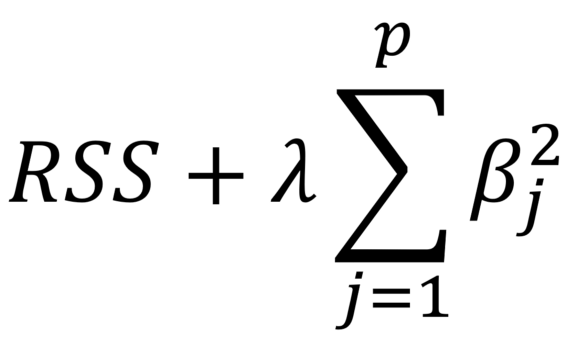

Where lambda is a tuning parameter. This parameter is found using cross-validation as it must minimize the test error. Therefore, a range of lambdas is used to fit the model and the lambda that minimizes the test error is the optimal value.
Here, ridge regression will include all p predictors in the model. Hence, it is a good method to improve the fit of the model, but it will not perform variable selection. In order to tune its hyperparameter, alpha, we try some common valus for it and draw MSE of train and test for each alpha and the best error that i achieved using idge is 294000 whixh is for alpha = 0.1 .

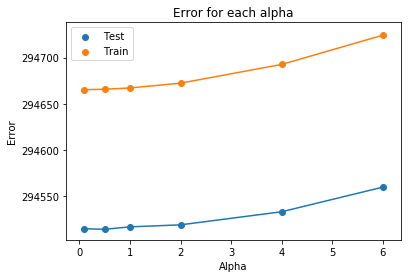

In [62]:
alpha = [0.1, 0.5, 1, 2, 4, 6] 
testAccuracies = []
trainAccuracies = []
for i in alpha:
    model = Ridge(solver = "sag", random_state = 7, alpha = i, copy_X = True)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    testAccuracies.append(np.sqrt(mean_squared_error(y_test, predictions)))
    predictions = model.predict(X_train)
    trainAccuracies.append(np.sqrt(mean_squared_error(y_train, predictions)))
fig, ax = plt.subplots()
ax.plot(alpha, testAccuracies)
ax.scatter(alpha, testAccuracies, label = 'Test')
ax.plot(alpha, trainAccuracies)
ax.scatter(alpha, trainAccuracies, label = 'Train')
plt.legend(loc = 'upper left');
plt.title("Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()

In [63]:
print('MSE for Linear Regression:', testAccuracies[0])

MSE for Linear Regression: 294514.48293438886


One other regresser I used is SVM. SVM or Support Vector regression is a type of Support vector machine that supports linear and non-linear regression. As it seems in the below graph, the mission is to fit as many instances as possible between the lines while limiting the margin violations. The violation concept in this example represents as ε (epsilon). SVR requires the training data:{ X, Y} which covers the domain of interest and is accompanied by solutions on that domain. The work of the SVM is to approximate the function we used to generate the training set to reinforce some of the information we’ve already discussed in a classification problem.

D:\Anaconda\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminate

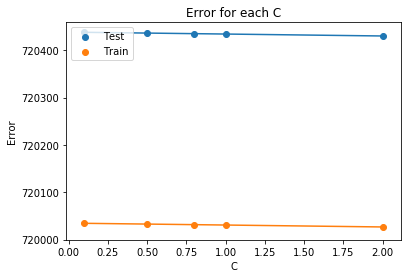

In [44]:
Cs = [0.1, 0.5, 0.8, 1, 2] 
testAccuracies = []
trainAccuracies = []
for c in Cs:
    model = SVR(C = c, max_iter = 200)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    testAccuracies.append(np.sqrt(mean_squared_error(y_test, predictions)))
    predictions = model.predict(X_train)
    trainAccuracies.append(np.sqrt(mean_squared_error(y_train, predictions)))
fig, ax = plt.subplots()
ax.plot(Cs, testAccuracies)
ax.scatter(Cs, testAccuracies, label = 'Test')
ax.plot(Cs, trainAccuracies)
ax.scatter(Cs, trainAccuracies, label = 'Train')
plt.legend(loc = 'upper left');
plt.title("Error for each C")
plt.xlabel("C")
plt.ylabel("Error")
plt.show()

We can see that our error doubled which shows us that SVM is not a good nmodel for this dataset.
The last model I used is LGBM which is a gradient boosting model that uses tree-based learning algorithms. Unfortunately because of limited time i couldn't completely implement this model because it has many hyperparameters and it had some barriesr for persian text learning. But from my implementation, it is seen that it won;t do any better that other models since its error is nan in most cases.

In [61]:
lgb_model = LGBMRegressor(subsample=0.9)
params = {'learning_rate':uniform(0, 1),
          'n_estimators': sp_randint(200, 1500),
          'num_leaves': sp_randint(20, 200),
          'max_depth': sp_randint(2, 15),
          'min_child_weight': uniform(0, 2),
          'colsample_bytree': uniform(0, 1),
         }
lgb_random = RandomizedSearchCV(lgb_model, param_distributions=params, n_iter=10, cv=3, random_state=7, 
                                scoring='neg_root_mean_squared_error', verbose=10, return_train_score=True)
lgb_random = lgb_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] colsample_bytree=0.07630828937395717, learning_rate=0.7799187922401146, max_depth=5, min_child_weight=1.956445794157165, n_estimators=1409, num_leaves=162 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Do not support non-ASCII characters in feature name.

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  colsample_bytree=0.07630828937395717, learning_rate=0.7799187922401146, max_depth=5, min_child_weight=1.956445794157165, n_estimators=1409, num_leaves=162, score=(train=nan, test=nan), total=   1.0s
[CV] colsample_bytree=0.07630828937395717, learning_rate=0.7799187922401146, max_depth=5, min_child_weight=1.956445794157165, n_estimators=1409, num_leaves=162 
[CV]  colsample_bytree=0.07630828937395717, learning_rate=0.7799187922401146, max_depth=5, min_child_weight=1.956445794157165, n_estimators=1409, num_leaves=162, score=(train=nan, test=nan), total=   0.8s
[CV] colsample_bytree=0.07630828937395717, learning_rate=0.7799187922401146, max_depth=5, min_child_weight=1.956445794157165, n_estimators=1409, num_leaves=162 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s


[CV]  colsample_bytree=0.07630828937395717, learning_rate=0.7799187922401146, max_depth=5, min_child_weight=1.956445794157165, n_estimators=1409, num_leaves=162, score=(train=nan, test=nan), total=   0.8s
[CV] colsample_bytree=0.26387083903789865, learning_rate=0.08674342983999195, max_depth=12, min_child_weight=0.5368779602037423, n_estimators=1391, num_leaves=88 
[CV]  colsample_bytree=0.26387083903789865, learning_rate=0.08674342983999195, max_depth=12, min_child_weight=0.5368779602037423, n_estimators=1391, num_leaves=88, score=(train=nan, test=nan), total=   0.8s
[CV] colsample_bytree=0.26387083903789865, learning_rate=0.08674342983999195, max_depth=12, min_child_weight=0.5368779602037423, n_estimators=1391, num_leaves=88 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.5s remaining:    0.0s


[CV]  colsample_bytree=0.26387083903789865, learning_rate=0.08674342983999195, max_depth=12, min_child_weight=0.5368779602037423, n_estimators=1391, num_leaves=88, score=(train=nan, test=nan), total=   0.8s
[CV] colsample_bytree=0.26387083903789865, learning_rate=0.08674342983999195, max_depth=12, min_child_weight=0.5368779602037423, n_estimators=1391, num_leaves=88 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.3s remaining:    0.0s


[CV]  colsample_bytree=0.26387083903789865, learning_rate=0.08674342983999195, max_depth=12, min_child_weight=0.5368779602037423, n_estimators=1391, num_leaves=88, score=(train=nan, test=nan), total=   0.8s
[CV] colsample_bytree=0.8688014582078086, learning_rate=0.3308392493496919, max_depth=2, min_child_weight=0.13187269381181022, n_estimators=450, num_leaves=26 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.2s remaining:    0.0s


[CV]  colsample_bytree=0.8688014582078086, learning_rate=0.3308392493496919, max_depth=2, min_child_weight=0.13187269381181022, n_estimators=450, num_leaves=26, score=(train=nan, test=nan), total=   0.8s
[CV] colsample_bytree=0.8688014582078086, learning_rate=0.3308392493496919, max_depth=2, min_child_weight=0.13187269381181022, n_estimators=450, num_leaves=26 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    6.0s remaining:    0.0s


[CV]  colsample_bytree=0.8688014582078086, learning_rate=0.3308392493496919, max_depth=2, min_child_weight=0.13187269381181022, n_estimators=450, num_leaves=26, score=(train=nan, test=nan), total=   0.8s
[CV] colsample_bytree=0.8688014582078086, learning_rate=0.3308392493496919, max_depth=2, min_child_weight=0.13187269381181022, n_estimators=450, num_leaves=26 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    6.8s remaining:    0.0s


[CV]  colsample_bytree=0.8688014582078086, learning_rate=0.3308392493496919, max_depth=2, min_child_weight=0.13187269381181022, n_estimators=450, num_leaves=26, score=(train=nan, test=nan), total=   0.8s
[CV] colsample_bytree=0.9095935277196137, learning_rate=0.2133853535799155, max_depth=7, min_child_weight=1.859056382346243, n_estimators=383, num_leaves=132 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    7.6s remaining:    0.0s


[CV]  colsample_bytree=0.9095935277196137, learning_rate=0.2133853535799155, max_depth=7, min_child_weight=1.859056382346243, n_estimators=383, num_leaves=132, score=(train=nan, test=nan), total=   0.8s
[CV] colsample_bytree=0.9095935277196137, learning_rate=0.2133853535799155, max_depth=7, min_child_weight=1.859056382346243, n_estimators=383, num_leaves=132 
[CV]  colsample_bytree=0.9095935277196137, learning_rate=0.2133853535799155, max_depth=7, min_child_weight=1.859056382346243, n_estimators=383, num_leaves=132, score=(train=nan, test=nan), total=   0.8s
[CV] colsample_bytree=0.9095935277196137, learning_rate=0.2133853535799155, max_depth=7, min_child_weight=1.859056382346243, n_estimators=383, num_leaves=132 
[CV]  colsample_bytree=0.9095935277196137, learning_rate=0.2133853535799155, max_depth=7, min_child_weight=1.859056382346243, n_estimators=383, num_leaves=132, score=(train=nan, test=nan), total=   0.8s
[CV] colsample_bytree=0.6005489174641225, learning_rate=0.950129500413645

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   25.1s finished


LightGBMError: Do not support non-ASCII characters in feature name.

## Conclusion:
We got an MSE of around 290000 for out price predictor which is a good error because of 5 reasons:
1 - Dataset was from Divar.com which is a site that peaple put their own ads in ordet to sell their products so the prices are not accurate enough and it has many noises such as misclicks and so on. Dataset of a site like Torob would be much better because real time sellers put prices there and they are more accurate.
2 - Our dataset did not have many usefull features and we had to drop most of them.
3 - Description of a mobile ad is not a very useful thin in order to predict its price because ther could have been many errors and noises in it and a table of mobile features could have been a perfetct dataset for this purpose.
4 - Hazm tool was not as good as nltk and needs a lot more develpoment.If this dataset was in english, the results would have been mich higher.
5 - Data might have not been enough for this task because there are thousands of mobile models and a 60000 dataset won't be enough for this purpose.
At the end I think we could have got a lower error if:
1 - we used tf-idf measure instead of countong words
2 - Neural networks such as RNN and CNN would have been better for this purpose
3 - Workin more on preprocess of persian texts could have been a realy effective job because there were many bugs in Hazm.